In [2]:
!pip install prophet

     |████████████████████████████████| 71kB 3.8MB/s 
     |████████████████████████████████| 51kB 4.1MB/s 
     |████████████████████████████████| 184kB 6.3MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6638754 sha256=da104cf5547b139f1e87eff783ec16a5965a271636ac6abe2ba7d1da55a2e6cc
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [3]:
!pip install neuralprophet

     |████████████████████████████████| 61kB 2.0MB/s 
     |████████████████████████████████| 748.8MB 19kB/s 
     |████████████████████████████████| 81kB 7.7MB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [4]:
import fbprophet
import pandas as pd
import numpy as np
from glob import glob
from matplotlib import pyplot

from datetime import datetime
from neuralprophet import NeuralProphet

In [5]:
print(fbprophet.__version__)

0.7.1


In [6]:
path = '/content/drive/MyDrive/data/'

In [82]:
files = sorted(glob(path+'*.csv'))

site_info = pd.read_csv(files[4],  encoding='cp949') # 발전소 정보, UnicodeDecodeError 해결
energy = pd.read_csv(files[2]) # 발전소별 발전량

dangjin_fcst_data = pd.read_csv(files[0]) # 당진 예보 데이터
dangjin_obs_data = pd.read_csv(files[1], encoding='cp949') # 당진 기상 관측 자료

ulsan_fcst_data = pd.read_csv(files[5]) # 울산 예보 데이터
ulsan_obs_data = pd.read_csv(files[6], encoding='cp949') # 울산 기상 관측 자료

sample_submission = pd.read_csv(files[3]) # 제출 양식

In [83]:
energy

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2018-03-01 1:00:00,0.0,0.0,0,0
1,2018-03-01 2:00:00,0.0,0.0,0,0
2,2018-03-01 3:00:00,0.0,0.0,0,0
3,2018-03-01 4:00:00,0.0,0.0,0,0
4,2018-03-01 5:00:00,0.0,0.0,0,0
...,...,...,...,...,...
25627,2021-01-31 20:00:00,0.0,0.0,0,0
25628,2021-01-31 21:00:00,0.0,0.0,0,0
25629,2021-01-31 22:00:00,0.0,0.0,0,0
25630,2021-01-31 23:00:00,0.0,0.0,0,0


In [99]:
# 결측치 일단 평균값으로 처리 (neuralprophet 결측치 30개 이상이면 안돌아감) 

energy['dangjin_floating'] = energy['dangjin_floating'].fillna(energy['dangjin_floating'].mean())
energy['dangjin_warehouse'] = energy['dangjin_warehouse'].fillna(energy['dangjin_warehouse'].mean())

In [100]:
energy['dangjin_warehouse'].isnull().sum()

0

In [101]:
energy['dangjin_floating'].isnull().sum()

0

In [86]:
sample_submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,0,0,0,0
1,2021-02-01 02:00:00,0,0,0,0
2,2021-02-01 03:00:00,0,0,0,0
3,2021-02-01 04:00:00,0,0,0,0
4,2021-02-01 05:00:00,0,0,0,0
...,...,...,...,...,...
1387,2021-07-08 20:00:00,0,0,0,0
1388,2021-07-08 21:00:00,0,0,0,0
1389,2021-07-08 22:00:00,0,0,0,0
1390,2021-07-08 23:00:00,0,0,0,0


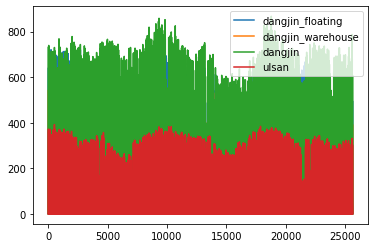

In [87]:
energy.plot()

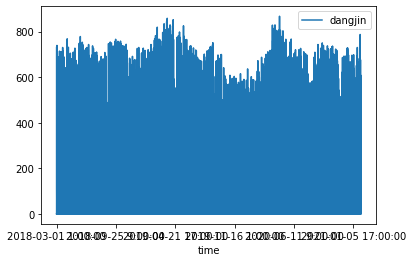

In [88]:
plt = energy.plot(x='time', y='dangjin')

In [89]:
# 페이스북 neuralprophet model

def convert_time(x):
    Ymd, HMS = x.split(' ')
    H, M, S = HMS.split(':')
    H = str(int(H)-1)
    HMS = ':'.join([H, M, S])
    return ' '.join([Ymd, HMS])

In [102]:
# 데이터 불러오기
train_data = energy
# 시간 변환
train_data['time'] = train_data['time'].apply(lambda x:convert_time(x))

In [103]:
column1 = 'dangjin_floating'
df1 = pd.DataFrame()
df1['ds'] = train_data['time']
df1['y'] = train_data[column1]

In [107]:
column2 = 'dangjin_warehouse'
df2 = pd.DataFrame()
df2['ds'] = train_data['time']
df2['y'] = train_data[column2]

In [108]:
column3 = 'dangjin'
df3 = pd.DataFrame()
df3['ds'] = train_data['time']
df3['y'] = train_data[column3]

In [109]:
column4 = 'ulsan'
df4 = pd.DataFrame()
df4['ds'] = train_data['time']
df4['y'] = train_data[column4]

In [110]:
# 모델 설정 (floating)
model = NeuralProphet()
# 훈련
loss = model.fit(df1, freq="H")
# 예측용 데이터 프레임 만들기
df_pred = model.make_future_dataframe(df1, periods=18000)
# 예측
predict1 = model.predict(df_pred)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s, SmoothL1Loss=0.0162, MAE=70.7, RegLoss=0]


In [111]:
# 모델 설정 (warehouse)
model = NeuralProphet()
# 훈련
loss = model.fit(df2, freq="H")
# 예측용 데이터 프레임 만들기
df_pred = model.make_future_dataframe(df2, periods=18000)
# 예측
predict2 = model.predict(df_pred)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s, SmoothL1Loss=0.0158, MAE=53.2, RegLoss=0]


In [112]:
# 모델 설정 (dangjin)
model = NeuralProphet()
# 훈련
loss = model.fit(df3, freq="H")
# 예측용 데이터 프레임 만들기
df_pred = model.make_future_dataframe(df3, periods=18000)
# 예측
predict3 = model.predict(df_pred)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s, SmoothL1Loss=0.0155, MAE=78.8, RegLoss=0]


In [113]:
# 모델 설정 (ulsan)
model = NeuralProphet()
# 훈련
loss = model.fit(df4, freq="H")
# 예측용 데이터 프레임 만들기
df_pred = model.make_future_dataframe(df4, periods=18000)
# 예측
predict4 = model.predict(df_pred)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s, SmoothL1Loss=0.0163, MAE=37.2, RegLoss=0]


In [114]:
submission = sample_submission

In [115]:
# floating
# 2021-02-01 ~ 2021-03-01
predict_1 = predict1.copy()
predict_1 = predict_1.query('ds >= "2021-02-01 00:00:00"')
predict_1 = predict_1.query('ds < "2021-03-01 00:00:00"')

# 2021-06-09 ~ 2021-07-09
predict_2 = predict1.copy()
predict_2 = predict_2.query('ds >= "2021-06-09 00:00:00"')
predict_2 = predict_2.query('ds < "2021-07-09 00:00:00"')

# 제출 파일 업데이트
submission[column1] = list(predict_1['yhat1']) + list(predict_2['yhat1'])

In [116]:
# warehouse
# 2021-02-01 ~ 2021-03-01
predict_1 = predict2.copy()
predict_1 = predict_1.query('ds >= "2021-02-01 00:00:00"')
predict_1 = predict_1.query('ds < "2021-03-01 00:00:00"')

# 2021-06-09 ~ 2021-07-09
predict_2 = predict2.copy()
predict_2 = predict_2.query('ds >= "2021-06-09 00:00:00"')
predict_2 = predict_2.query('ds < "2021-07-09 00:00:00"')

# 제출 파일 업데이트
submission[column2] = list(predict_1['yhat1']) + list(predict_2['yhat1'])

In [117]:
# dangjin
# 2021-02-01 ~ 2021-03-01
predict_1 = predict3.copy()
predict_1 = predict_1.query('ds >= "2021-02-01 00:00:00"')
predict_1 = predict_1.query('ds < "2021-03-01 00:00:00"')

# 2021-06-09 ~ 2021-07-09
predict_2 = predict3.copy()
predict_2 = predict_2.query('ds >= "2021-06-09 00:00:00"')
predict_2 = predict_2.query('ds < "2021-07-09 00:00:00"')

# 제출 파일 업데이트
submission[column3] = list(predict_1['yhat1']) + list(predict_2['yhat1'])

In [118]:
# ulsan
# 2021-02-01 ~ 2021-03-01
predict_1 = predict4.copy()
predict_1 = predict_1.query('ds >= "2021-02-01 00:00:00"')
predict_1 = predict_1.query('ds < "2021-03-01 00:00:00"')

# 2021-06-09 ~ 2021-07-09
predict_2 = predict4.copy()
predict_2 = predict_2.query('ds >= "2021-06-09 00:00:00"')
predict_2 = predict_2.query('ds < "2021-07-09 00:00:00"')

# 제출 파일 업데이트
submission[column4] = list(predict_1['yhat1']) + list(predict_2['yhat1'])

In [119]:
submission.head()

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,-23.507988,-20.414013,-26.272640,6.493210
1,2021-02-01 02:00:00,-21.065453,-21.815409,-27.334141,3.332325
2,2021-02-01 03:00:00,-20.976917,-22.386423,-24.324429,3.244762
3,2021-02-01 04:00:00,-20.914921,-20.530066,-24.784733,6.755749
4,2021-02-01 05:00:00,-19.770889,-18.607367,-29.044220,7.565102


In [120]:
submission.to_csv(path+'submission.csv', index=False)